Name: Sirinian Aram Emmanouil,
AM: 2537

Ερώτηση 4

Σε αυτή την ερώτηση θα χρησιμοποιήσετε τα δεδομένα που δημιουργήσατε για την Δεύτερη Σειρά Ασκήσεων, 
για τα συστήματα συστάσεων. Ο στόχος είναι να χρησιμοποιήσουμε το κοινωνικό δίκτυο μεταξύ των χρηστών του Yelp για να προβλέψουμε τα ratings τους για νέες επιχειρήσεις.

Ξεκινήστε με τα δεδομένα από την Δεύτερη Σειρά, τα οποία αποτελούνται από τις επιχειρήσεις στο Toronto που έχουν τουλάχιστον 10 κριτικές από χρήστες με τουλάχιστον 10 κριτικές. Χρησιμοποιώντας αυτούς τους χρήστες ως τις κορυφές, δημιουργείστε ένα γράφημα με ακμές τις φιλίες μεταξύ των χρηστών, τις οποίες θα πάρετε από το αρχείο user.json. Από αυτό το γράφημα κρατήστετη μεγαλύτερη συνεκτική συνιστώσα. Αυτή θα ορίσει το γράφημα 퐺 με το οποίο θα δουλέψετε , και οι κόμβοι της συνιστώσας το σύνολο των χρηστών που μας ενδιαφέρουν (το σύνολο των επιχειρήσεων παραμένει το ίδιο).

Αφαιρέστε τυχαία 10% των ratings χρηστών και προσπαθήστε να προβλέψετε το rating για το ζευγάρι χρήστη-επιχείρηση(푢,푏)
χρησιμοποιώντας ένα τυχαίο περίπατο με απορροφητικούς κόμβους, ως εξής : Δεδομένου του ζεύγους (푢,푏) και το γράφημα 퐺, κάνετε κάθε κόμβο 푣 ο οποίος έχει δώσει rating για την επιχείρηση푏 να είναι απορροφητικός, και αναθέστε του τιμή ίση με το rating 푅(푣,푏). 

Χρησιμοποιώντας την τεχνική για την διάχυση (propagation) τιμών που περιγράψαμε στην τάξη, υπολογίστε ένα rating 푃(푣′,푏) για κάθε μη-απορροφητικό κόμβο 푣′στο γράφημα. Η πρόβλεψη για τον κόμβο 푢 θα είναι η τιμή 푃(푢,푏). Υπολογίσετε το Root Mean Square Error(RMSE) για αυτή τη μέθοδο. Στη συνέχεια, τρέξετε τους αλγορίθμους που υλοποιήσατε στην Δεύτερη Σειρά (Ερώτηση 3) για αυτό το dataset και συγκρίνετε το Root Mean Square Error(RMSE). Παρουσιάστε τα
αποτελέσματα σας και γράψετε τις παρατηρήσεις σας.

Bonus: Προτείνετε, υλοποιήστε και τεστάρετε μια διαφορετική μέθοδο που να προβλέπει τα ratings των χρηστών χρησιμοποιώντας
το γράφημα των φιλιών μεταξύ των χρηστών. Περιγράψετε την μέθοδο σας και τα 

In [2]:
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from datetime import datetime
from collections import Counter
import json
import time
import random
import scipy.sparse as sp_sparse
import sklearn.metrics.pairwise as cossim
import heapq
import math
from operator import itemgetter
%matplotlib inline

In [3]:
def UpdateBusinessCount(business_id):
    business_data[business_id] +=1

def UpdateUserCount(user_id):
    user_data[user_id] +=1

Collecting useful data from business.json and view.json

In [4]:
user_data = {}
business_data = {}
review_data = []
tempArray = []
flag = True
old_len_of_review_data = 99999999
new_len_of_review_data = 0
user_data_g9 = set()
business_data_g9 = set()

while( (old_len_of_review_data - new_len_of_review_data) > 0 ):
    if(flag):   
        with open('business.json') as f:
            for line in f:
                try:
                    if(json.loads(line.strip())["city"] == "Toronto"):
                        business_data[(json.loads(line.strip())["business_id"])] = 0
                except ValueError:
                    pass

        with open('review.json') as f:
            for line in f:
                try:
                    x = json.loads(line.strip())
                    if((x["user_id"]) in user_data):
                        UpdateUserCount(x["user_id"])
                    if((x["user_id"]) not in user_data):
                        user_data[(x["user_id"])] = 1
                    if((x["business_id"]) in business_data):
                        UpdateBusinessCount(x["business_id"])
                    review_data.append((x["user_id"], x["business_id"], x["stars"]))
                except ValueError:
                    pass

        flag = False
    else:
        tempArray = []
        for x in review_data:
            tempArray.append(x[0])
        tempArray = set(tempArray)
        for x in tempArray:
            user_data[x] = 0

        tempArray = []
        for x in review_data:
            tempArray.append(x[1])
        tempArray = set(tempArray)
        for x in tempArray:
            business_data[x] = 0

        for x in review_data:
            if((x[0]) in user_data):
                UpdateUserCount(x[0])
            if((x[1]) in business_data):
                UpdateBusinessCount(x[1])

    old_len_of_review_data = len(review_data)

    tempArray = []
    for key, value in user_data.items():
        if(value>9):
            tempArray.append(key)
    user_data_g9 = set(tempArray)

    tempArray = []
    for key, value in business_data.items():
        if(value>9):
            tempArray.append(key)
    business_data_g9 = set(tempArray)

    tempArray = []
    for x in review_data:
        if( (x[0] in user_data_g9) and (x[1] in business_data_g9) ):
            tempArray.append((x[0], x[1], x[2]))
    review_data = tempArray

    new_len_of_review_data = len(review_data)

In [5]:
users_in_final_review_data = []

for x in review_data:
    users_in_final_review_data.append(x[0])
    
users_in_final_review_data = set(users_in_final_review_data)

Computing graph G

In [6]:
import networkx as nx
%matplotlib inline

fG = nx.Graph()

for x in users_in_final_review_data:
    fG.add_node(x)

with open('user.json') as f:
            for line in f:
                try:
                    temp_user_id = json.loads(line.strip())['user_id']
                    if (temp_user_id in users_in_final_review_data):
                        temp_friends = json.loads(line.strip())['friends']
                        for x in temp_friends:
                            if (x in users_in_final_review_data):
                                fG.add_edge(temp_user_id, x)
                except ValueError:
                    pass

In [7]:
G = max(nx.connected_component_subgraphs(fG),key=len)
print('max')
print(len(G.nodes()))

max
3975


Removing random 10% with users in G

In [8]:
number_of_ratings = len(review_data)
ps10 = (int) (abs( (number_of_ratings * 10) / 100 ))
random_ps10 = []
temp_review_data = list(review_data)

while (len(random_ps10) < (ps10)):
    number_of_ratings = len(temp_review_data)
    temp_random_position_in_temp_review_data = random.choice(range(number_of_ratings + 1))
    user_in_random_position = temp_review_data[temp_random_position_in_temp_review_data][0]
    if (user_in_random_position in G.nodes()):
        random_ps10.append( temp_review_data.pop(temp_random_position_in_temp_review_data) )

review_data_without_random_ps10_nodes = list(temp_review_data)
temp_review_data = []

In [9]:
print(number_of_ratings)
print(len(random_ps10))
print(random_ps10[0])
print(len(users_in_final_review_data))
print("##################################")
temp_value = 0
for GC in nx.connected_component_subgraphs(fG):
    #print(GC.nodes())
    temp_value += len(GC.nodes())
    print(len(GC.nodes()))
print(temp_value)

159207
17689
('UByCy7oxeiqFKOLmGUVm3g', 'yuFdJdrnfMp3cfXVwTXjjA', 3)
5954
##################################
1
3975
2
3
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


Absorbing Random Walks

In [80]:
def compute_Absorbing_Random_Walks(u, b, complexity):
    G2 = nx.DiGraph()

    tempArray = G.edges()
    for x in tempArray:
        G2.add_weighted_edges_from([(x[0], x[1], 1)])
        G2.add_weighted_edges_from([(x[1], x[0], 1)])
        G2.node[x[0]]['value'] = 0
        G2.node[x[1]]['value'] = 0
        G2.node[x[0]]['type'] = 0
        G2.node[x[1]]['type'] = 0

    temp_Array_of_sink_nodes = []

    for x in review_data_without_random_ps10_nodes:
        if (x[1] == b):
            if (x[0] not in G2.nodes()):
                continue
            temp_Array_of_sink_nodes.append(x[0])
            G2.node[x[0]]['type'] = 1
            G2.node[x[0]]['value'] = x[2]

    for x in temp_Array_of_sink_nodes:
        for y in G2.edges():
            if(y[0] == x):
                G2.remove_edge(y[0],y[1])

    while True:
        max_difr99 = 0 #the name is prity random :b

        for z in (G2.nodes()):
            if(G2.node[z]['type'] == 1):
                continue

            temp_dieretis = 0
            for x in (G2.neighbors(z)):
                temp_dieretis += G2[z][x]['weight']

            temp_kati = 0
            for x in (G2.neighbors(z)):
                temp_kati += ( G2[z][x]['weight']/temp_dieretis ) * G2.node[x]["value"]

            if (max_difr99 < abs(temp_kati - G2.node[z]["value"])):
                max_difr99 = abs(temp_kati - G2.node[z]["value"])

            G2.node[z]["value"] = temp_kati
        if(max_difr99 <= complexity):#0.001
            break

    if (u not in G2.nodes()):
        print("Node u: " + str(u) + "not in G2.nodes")
        return -666
    return G2.node[u]['value']

Creating two sparse matrices, one for all collected data and one without random 10% of it.

In [12]:
tempArray = []
tempArray2 = []
for x in review_data:
    tempArray.append(x[0])
    tempArray2.append(x[1])
user_data_for_all = list(set(tempArray))
business_data_for_all = list(set(tempArray2))

review_data2 = [list(x) for x in review_data]

for x in review_data2:
    x[0] = user_data_for_all.index(x[0])
    x[1] = business_data_for_all.index(x[1])

tempArray = []
tempArray2 = []

In [13]:
tempArray = []
tempArray2 = []
review_data3_dict = {}
for x in review_data_without_random_ps10_nodes:
    tempArray.append(x[0])
    tempArray2.append(x[1])
user_data_g9 = list(set(tempArray))
business_data_g9 = list(set(tempArray2))

review_data3 = [list(x) for x in review_data_without_random_ps10_nodes]

for x in review_data3:
    x[0] = user_data_g9.index(x[0])
    x[1] = business_data_g9.index(x[1])
    review_data3_dict[x[0], x[1]] = x[2]

tempArray = []
tempArray2 = []

In [14]:
print(len(review_data2))
print(len(review_data3))

176895
159206


In [15]:
row2 = [] # user_data_for_all
col2 = [] # business_data_for_all
data2 = [] # ratings

for x in review_data2:
    row2.append(x[0])
    col2.append(x[1])
    data2.append(x[2])

In [16]:
print(review_data2[0])
print(review_data3[0])

[2184, 3205, 3]
[2184, 3205, 3]


In [17]:
M2 = sp_sparse.csr_matrix((data2,(row2,col2)))
M2 = sp_sparse.lil_matrix(M2)

In [18]:
row3 = [] # user_data_g9
col3 = [] # business_data_g9
data3 = [] # ratings

for x in review_data3:
    row3.append(x[0])
    col3.append(x[1])
    data3.append(x[2])

In [19]:
M = sp_sparse.csr_matrix((data3,(row3,col3)))
M = sp_sparse.lil_matrix(M)

In [20]:
row3 = []
col3 = []
data3 = []
row2 = []
col2 = []
data2 = []

In [22]:
M2

<5954x4823 sparse matrix of type '<class 'numpy.int64'>'
	with 176895 stored elements in LInked List format>

User Average (UA) & Business Average (BA)

In [23]:
(x,y,z) = sp_sparse.find(M)
countings = np.bincount(x)
sums=np.bincount(x,weights=z)
averages_of_M = sums/countings

(x,y,z) = sp_sparse.find(M.T)
countings = np.bincount(x)
sums=np.bincount(x,weights=z)
averages_of_MT = sums/countings

def getUA(user):
    return averages_of_M[user_data_g9.index(user)]

def getBA(business):
    return averages_of_MT[business_data_g9.index(business)]

In [24]:
print(averages_of_M)
print(averages_of_MT)

[ 3.5         3.6         3.75       ...,  4.8         4.          2.33333333]
[ 3.65517241  3.57142857  3.27777778 ...,  3.73529412  3.25        3.92857143]


User-based Collaborative Filtering (UCF)

In [25]:
def normalizedCosineSimilarity(array1, array2):
    temp_array1 = array1[:]
    temp_array2 = array2[:]
    for i in range(len(temp_array1)):
        if(temp_array1[i] == 0):
            temp_array1[i] = np.nan
        if(temp_array2[i] == 0):
            temp_array2[i] = np.nan
    
    mean_temp_array1 = np.nanmean(temp_array1)
    mean_temp_array2 = np.nanmean(temp_array2)
    
    temp_array1 = np.nan_to_num(np.subtract(temp_array1, [mean_temp_array1]))
    temp_array2 = np.nan_to_num(np.subtract(temp_array2, [mean_temp_array2]))
    
    cosine_similarity = cossim.cosine_similarity([temp_array1, temp_array2])[0,1]
    return cosine_similarity

In [26]:
a = [4, 0, 0, 5, 1, 0, 0]
b = [5, 5, 4, 0, 0, 0, 0]
c = [0, 0, 0, 2, 4, 5, 0]
d = [0, 3, 0, 0, 0, 0, 3]

print(normalizedCosineSimilarity(a, b))
print(normalizedCosineSimilarity(a, c))

0.0924500327042
-0.559085246252


In [27]:
def mostSimilarUsers(user, business, k):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    temp_similarity_dict = {}
    
    tempArray = []
    tempArray2 = []
    tempArray2 = M.T[business_id].toarray().tolist()[0]
    for i in range(len(tempArray2)):
        if(tempArray2[i] > 0):
            tempArray.append(i)
    
    for i in tempArray:
        temp_normalized_cosine_similarity = normalizedCosineSimilarity(M[user_id].toarray().tolist()[0], M[i].toarray().tolist()[0])
        temp_similarity_dict[i] = temp_normalized_cosine_similarity
    k_top_items = heapq.nlargest(n=k, iterable=temp_similarity_dict.items(), key=itemgetter(1))
    return dict(k_top_items)

In [28]:
def equationUCF(user, business, k):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    user_mean = getUA(user)
    p = user_mean
    temp_numerator = 0
    temp_denominator = 0
    most_similar_users = mostSimilarUsers(user, business, k)
    most_similar_users_keys = list(most_similar_users.keys())
    
    range_of_most_similar_users = len(most_similar_users_keys)
    
    for i in range(range_of_most_similar_users):
        similarity_user_user2 = 0
        user2_rating = 0
        user2_mean = 0
        
        similarity_user_user2 = most_similar_users[most_similar_users_keys[i]]

        user2_rating = review_data3_dict[(most_similar_users_keys[i], business_id)]
        
        user2_mean = getUA(user_data_g9[most_similar_users_keys[i]])
        
        temp_numerator += similarity_user_user2 * (user2_rating - user2_mean)
        temp_denominator += similarity_user_user2
    
    p += ( temp_numerator / temp_denominator )
    if(p>5):
        return 5.0
    if(p<1):
        return 1.0
    return p

Item-based Collaborative Filtering (ΙCF)

In [29]:
def cosineSimilarity(array1, array2):
    tempArray = [array1, array2]
    return cossim.cosine_similarity(tempArray)[0,1]

In [30]:
d1 = [3, 2, 0, 5, 0, 0, 0, 2, 0, 0]
d2 = [1, 0, 0, 0, 0, 0, 0, 1, 0, 2]

print(cosineSimilarity(d1, d2))

0.314970394174


In [31]:
def mostSimilarBusinesses(user, business, k):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    temp_similarity_dict = {}
    
    tempArray = []
    tempArray2 = []
    tempArray2 = M[user_id].toarray().tolist()[0]
    for i in range(len(tempArray2)):
        if(tempArray2[i] > 0):
            tempArray.append(i)
    
    for i in tempArray:
        temp_cosine_similarity = cosineSimilarity(M.T[business_id].toarray().tolist()[0], M.T[i].toarray().tolist()[0])###TODO Find something faster for this one
        temp_similarity_dict[i] = temp_cosine_similarity
    k_top_items = heapq.nlargest(n=k, iterable=temp_similarity_dict.items(), key=itemgetter(1))
    return dict(k_top_items)

In [32]:
def equationICF(user, business, k):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    p = 0
    temp_numerator = 0
    temp_denominator = 0
    most_similar_businesses = mostSimilarBusinesses(user, business, k)
    
    most_similar_businesses_keys = list(most_similar_businesses.keys())
    
    range_of_most_similar_businesses = len(most_similar_businesses_keys)
    
    for i in range(range_of_most_similar_businesses):
        similarity_business_business2 = 0
        business2_rating = 0
        
        similarity_business_business2 = most_similar_businesses[most_similar_businesses_keys[i]]

        business2_rating = review_data3_dict[(user_id, most_similar_businesses_keys[i])]
        
        temp_numerator += similarity_business_business2 * business2_rating
        temp_denominator += similarity_business_business2
        
    p += ( temp_numerator / temp_denominator )
    return p

Singular Value Decomposition (SVD)

In [33]:
temp_time = time.time()

LA = np.linalg
np_array_M2 = np.array(M2.toarray().tolist())
U, s, Vh = LA.svd(np_array_M2, full_matrices=False)

print(str(time.time() - temp_time))

332.2355115413666


In [34]:
matrix_svd = []
def plotSfromMatrixSVD():
    plt.figure(figsize=(12,8))
    plt.plot(s[:])
    plt.ylabel('eigenvalue value')
    plt.xlabel('number of eigenvalues')

def createMatrixSVD(k):
    s[k:] = 0
    new_tempArray = np.dot(U, np.dot(np.diag(s), Vh))
    return new_tempArray

def reduce_dimensions_of_matrix_SVD(k):
    global matrix_svd
    matrix_svd = createMatrixSVD(k)

def equationSVD(user, business):
    user_id = user_data_g9.index(user)
    business_id = business_data_g9.index(business)
    return matrix_svd[user_id][business_id]

def recreateS():
    global s
    s = LA.svd(np_array_M2, full_matrices=False, compute_uv=False)

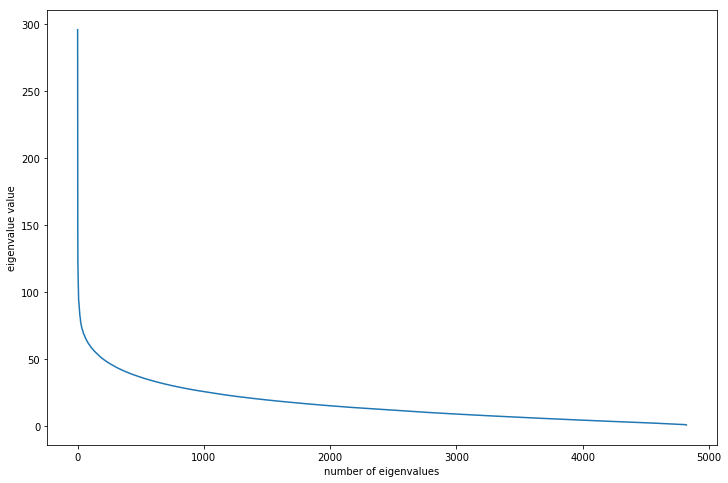

In [35]:
plotSfromMatrixSVD()

Creating lists with results of UA, BA, UCF, ICF and SVD

In [37]:
number_of_ratings = 10
number_of_k_values = 9
k_values = []

for i in range(number_of_k_values):
    k_values.append(int(round(np.exp(i))))

In [38]:
print(k_values)

[1, 3, 7, 20, 55, 148, 403, 1097, 2981]


In [40]:
temp_time = time.time()

sample_info = []
random_ps10_UCF = []
random_ps10_ICF = []

for i in range(number_of_ratings):
    random_ps10_id = random.choice(range(len(random_ps10) + 1))
    sample_info.append(random_ps10_id)

for i in range(number_of_ratings):
    temp_random_ps10_UCF = []
    temp_random_ps10_ICF = []
    for j in range(number_of_k_values):
        k_value_aka_rounded_exp = k_values[j]
        temp_random_ps10_UCF.append(equationUCF(random_ps10[sample_info[i]][0], random_ps10[sample_info[i]][1], k_value_aka_rounded_exp))
        temp_random_ps10_ICF.append(equationICF(random_ps10[sample_info[i]][0], random_ps10[sample_info[i]][1], k_value_aka_rounded_exp))
    random_ps10_UCF.append(temp_random_ps10_UCF)
    random_ps10_ICF.append(temp_random_ps10_ICF)

print(str(time.time() - temp_time))

2752.4534859657288


In [41]:
print(sample_info)
print(random_ps10_UCF)
print(random_ps10_ICF)

[12170, 13419, 12823, 4082, 7280, 1709, 4540, 9953, 5189, 1654]
[[2.895104895104895, 3.2514157289808692, 3.7080247942645284, 3.8063606502717895, 3.813476766919548, 2.701931328254239, 2.701931328254239, 2.701931328254239, 2.701931328254239], [4.7273722627737227, 4.1734672888123185, 3.7850459801096461, 3.5345047635195015, 3.5258952136062578, 3.5222301067261208, 3.5222301067261208, 3.5222301067261208, 3.5222301067261208], [5.0, 5.0, 4.9603652401752854, 4.8547595261262169, 4.7203835947126365, 4.9522547583316259, 4.9522547583316259, 4.9522547583316259, 4.9522547583316259], [2.3968531468531471, 2.748451076261325, 3.0294784233469034, 3.1884804757498779, 3.238924269518932, 3.1242986771089276, 3.1242986771089276, 3.1242986771089276, 3.1242986771089276], [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0], [3.3773722627737226, 3.2051083669621283, 3.412334035920201, 3.0516334040170356, 3.0516334040170356, 3.0516334040170356, 3.0516334040170356, 3.0516334040170356, 3.0516334040170356], [5.0, 5.0, 5.0, 5

In [43]:
temp_time = time.time()

random_ps10_UA = []
random_ps10_BA = []

for i in range(number_of_ratings):
    temp_random_ps10_UA = []
    temp_random_ps10_BA = []
    for j in range(number_of_k_values):
        temp_random_ps10_UA.append(getUA(random_ps10[sample_info[i]][0]))
        temp_random_ps10_BA.append(getBA(random_ps10[sample_info[i]][1]))
    random_ps10_UA.append(temp_random_ps10_UA)
    random_ps10_BA.append(temp_random_ps10_BA)

print(str(time.time() - temp_time))

0.0868995189666748


In [44]:
print(random_ps10_UA)
print(random_ps10_BA)

[[4.0769230769230766, 4.0769230769230766, 4.0769230769230766, 4.0769230769230766, 4.0769230769230766, 4.0769230769230766, 4.0769230769230766, 4.0769230769230766, 4.0769230769230766], [3.2773722627737225, 3.2773722627737225, 3.2773722627737225, 3.2773722627737225, 3.2773722627737225, 3.2773722627737225, 3.2773722627737225, 3.2773722627737225, 3.2773722627737225], [4.1086956521739131, 4.1086956521739131, 4.1086956521739131, 4.1086956521739131, 4.1086956521739131, 4.1086956521739131, 4.1086956521739131, 4.1086956521739131, 4.1086956521739131], [3.7045454545454546, 3.7045454545454546, 3.7045454545454546, 3.7045454545454546, 3.7045454545454546, 3.7045454545454546, 3.7045454545454546, 3.7045454545454546, 3.7045454545454546], [4.2999999999999998, 4.2999999999999998, 4.2999999999999998, 4.2999999999999998, 4.2999999999999998, 4.2999999999999998, 4.2999999999999998, 4.2999999999999998, 4.2999999999999998], [3.2773722627737225, 3.2773722627737225, 3.2773722627737225, 3.2773722627737225, 3.277372

In [45]:
random_ps10_SVD = []

for i in range(number_of_ratings):
    temp_random_ps10_SVD = []
    for j in range(number_of_k_values):
        temp_random_ps10_SVD2 = []
        temp_random_ps10_SVD.append(temp_random_ps10_SVD2)
    random_ps10_SVD.append(temp_random_ps10_SVD)

In [46]:
print(random_ps10_SVD)

[[[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], []]]


In [47]:
temp_time = time.time()

for i in range(number_of_k_values-1, -1, -1):
    k_value_aka_rounded_exp = k_values[i]
    reduce_dimensions_of_matrix_SVD(k_value_aka_rounded_exp)
    for j in range(number_of_ratings):
        random_ps10_SVD[j][i].append(equationSVD(random_ps10[sample_info[j]][0], random_ps10[sample_info[j]][1]))

print(str(time.time() - temp_time))

578.6484036445618


In [48]:
print(random_ps10_SVD)

[[[0.048734976666962103], [0.042873570168257311], [0.11721638720205647], [0.16073096018426233], [0.27941694971997011], [1.5769357193785887], [3.3757225784653353], [3.7503802581135446], [4.0055253760898157]], [[0.38557751875459012], [0.21471130294410795], [0.23045333229262585], [0.54845088427802258], [0.56027561157350581], [1.8764550802057538], [4.4655600854083968], [4.1667739454541879], [4.0116455337568713]], [[0.10249113577732588], [0.32478761829894465], [0.45819558690329987], [0.73776115050770896], [1.1570870949773879], [2.3843009224850937], [4.8504597532539044], [4.9426072488300354], [4.9857869760839719]], [[0.19234182762168758], [0.49269742770495784], [0.45616253209776136], [0.50960125747770535], [0.75176645977303314], [0.7671569923051561], [1.8785206555719227], [3.6107676307269965], [4.0426851120337286]], [[0.028623519169848708], [0.11168749694809749], [0.1716665577667052], [0.20833829543598786], [0.47691633463317706], [1.6002312862055481], [4.3874633146196267], [4.815646533160869

In [49]:
array_p = []

for i in sample_info:
    array_p.append(random_ps10[i][2])

In [50]:
print(array_p)

[4, 4, 5, 4, 5, 4, 5, 4, 5, 4]


In [51]:
array_r_UCF = []

for i in range(number_of_k_values):
    temp_array_r_UCF = []
    for j in range(number_of_ratings):
        temp_array_r_UCF.append(random_ps10_UCF[j][i])
    array_r_UCF.append(temp_array_r_UCF)

In [52]:
print(array_r_UCF)

[[2.895104895104895, 4.7273722627737227, 5.0, 2.3968531468531471, 5.0, 3.3773722627737226, 5.0, 4.5555555555555554, 4.5148514851485153, 3.9453098106712567], [3.2514157289808692, 4.1734672888123185, 5.0, 2.748451076261325, 5.0, 3.2051083669621283, 5.0, 4.601982133293343, 4.1794696219069358, 3.687585550388174], [3.7080247942645284, 3.7850459801096461, 4.9603652401752854, 3.0294784233469034, 5.0, 3.412334035920201, 5.0, 4.3281812850390393, 3.969887831612505, 3.7460563783305392], [3.8063606502717895, 3.5345047635195015, 4.8547595261262169, 3.1884804757498779, 5.0, 3.0516334040170356, 5.0, 4.4595931776983981, 3.8371143353704791, 3.8781231847083388], [3.813476766919548, 3.5258952136062578, 4.7203835947126365, 3.238924269518932, 5.0, 3.0516334040170356, 5.0, 4.3492819153208675, 3.7714613619782718, 3.9550896221946457], [2.701931328254239, 3.5222301067261208, 4.9522547583316259, 3.1242986771089276, 5.0, 3.0516334040170356, 5.0, 4.2819979264074908, 3.7934195814186249, 3.8919836795641434], [2.701

In [53]:
array_r_ICF = []

for i in range(number_of_k_values):
    temp_array_r_ICF = []
    for j in range(number_of_ratings):
        temp_array_r_ICF.append(random_ps10_ICF[j][i])
    array_r_ICF.append(temp_array_r_ICF)

In [54]:
print(array_r_ICF)

[[3.0, 4.0, 5.0, 5.0, 5.0, 3.0, 5.0000000000000009, 4.0, 1.0, 4.0], [3.7726118177323653, 4.3138446510662671, 4.0180249827169785, 4.3398550794091522, 3.9019844680398057, 3.0, 5.0000000000000009, 4.296115321553807, 2.1538487915552378, 4.0], [4.0629497415926279, 4.016595561643781, 4.5343608531150466, 4.0482354346668163, 4.1914280435761651, 3.3750145321875364, 4.7651412691125987, 4.0305537510064733, 3.0355594666714167, 3.8867985516817591], [4.0272017059325975, 3.4652494733441124, 4.4568398297667544, 4.1047572635867828, 4.2942390225632234, 3.2703365302113645, 4.7394030145019972, 3.8522799307897699, 3.3766917831237189, 3.5722317392045628], [4.0272017059325975, 3.3909953910055397, 4.3668110407658247, 3.9027452701905054, 4.2942390225632234, 3.2982246145989418, 4.7360736288108871, 3.8153529869370271, 3.4122505091841711, 3.4092538628692814], [4.0272017059325975, 3.3718977586792271, 4.3668110407658247, 3.9027452701905054, 4.2942390225632234, 3.2982246145989418, 4.7360736288108871, 3.8153529869370

In [55]:
array_r_UA = []
array_r_BA = []

for i in range(number_of_k_values):
    temp_array_r_UA = []
    temp_array_r_BA = []
    for j in range(number_of_ratings):
        temp_array_r_UA.append(random_ps10_UA[j][i])
        temp_array_r_BA.append(random_ps10_BA[j][i])
    array_r_UA.append(temp_array_r_UA)
    array_r_BA.append(temp_array_r_BA)

In [56]:
print(array_r_UA)
print(array_r_BA)

[[4.0769230769230766, 3.2773722627737225, 4.1086956521739131, 3.7045454545454546, 4.2999999999999998, 3.2773722627737225, 4.6086956521739131, 3.7555555555555555, 3.5148514851485149, 3.4392857142857145], [4.0769230769230766, 3.2773722627737225, 4.1086956521739131, 3.7045454545454546, 4.2999999999999998, 3.2773722627737225, 4.6086956521739131, 3.7555555555555555, 3.5148514851485149, 3.4392857142857145], [4.0769230769230766, 3.2773722627737225, 4.1086956521739131, 3.7045454545454546, 4.2999999999999998, 3.2773722627737225, 4.6086956521739131, 3.7555555555555555, 3.5148514851485149, 3.4392857142857145], [4.0769230769230766, 3.2773722627737225, 4.1086956521739131, 3.7045454545454546, 4.2999999999999998, 3.2773722627737225, 4.6086956521739131, 3.7555555555555555, 3.5148514851485149, 3.4392857142857145], [4.0769230769230766, 3.2773722627737225, 4.1086956521739131, 3.7045454545454546, 4.2999999999999998, 3.2773722627737225, 4.6086956521739131, 3.7555555555555555, 3.5148514851485149, 3.43928571

In [57]:
array_r_SVD = []

for i in range(number_of_k_values):
    temp_array_r_SVD = []
    for j in range(number_of_ratings):
        temp_array_r_SVD.append(random_ps10_SVD[j][i][0])
    array_r_SVD.append(temp_array_r_SVD)

In [58]:
print(array_r_SVD)

[[0.048734976666962103, 0.38557751875459012, 0.10249113577732588, 0.19234182762168758, 0.028623519169848708, 0.034504126877641497, 0.18929375029089734, 0.50301819000553871, 0.29843644977641881, 0.61384330459918435], [0.042873570168257311, 0.21471130294410795, 0.32478761829894465, 0.49269742770495784, 0.11168749694809749, 0.022672745473718302, 0.32662004271253098, 1.242984588021917, 0.042818860776273171, 0.32279008717418178], [0.11721638720205647, 0.23045333229262585, 0.45819558690329987, 0.45616253209776136, 0.1716665577667052, 0.016921175281228766, 0.59262539435224137, 3.0601921073793301, 0.37546778037243328, 0.38490268492734742], [0.16073096018426233, 0.54845088427802258, 0.73776115050770896, 0.50960125747770535, 0.20833829543598786, 0.03821864445758124, 0.57162539867181905, 4.0973855928165595, 0.24962053606273746, 0.13611927422246833], [0.27941694971997011, 0.56027561157350581, 1.1570870949773879, 0.75176645977303314, 0.47691633463317706, 0.20094097591440691, 1.4996227837645493, 4.1

Root Mean Square Error for UA, BA, UCF, ICF and SVD

In [59]:
def calculateRMSE(array_r, array_p):
    n = len(array_r)
    temp_sum = 0
    for i in range(n):
        temp_sub = array_r[i] - array_p[i]
        temp_sum += pow(temp_sub, 2)
    return math.sqrt(temp_sum/n)

In [60]:
temp_time = time.time()

array_r_UCF_RMSE = []
array_r_ICF_RMSE = []
array_r_UA_RMSE = []
array_r_BA_RMSE = []
array_r_SVD_RMSE = []


for i in range(number_of_k_values):
    array_r_UCF_RMSE.append( calculateRMSE(array_r_UCF[i], array_p) )
    array_r_ICF_RMSE.append( calculateRMSE(array_r_ICF[i], array_p) )
    array_r_UA_RMSE.append( calculateRMSE(array_r_UA[i], array_p) )
    array_r_BA_RMSE.append( calculateRMSE(array_r_BA[i], array_p) )
    array_r_SVD_RMSE.append( calculateRMSE(array_r_SVD[i], array_p) )

print(str(time.time() - temp_time))

0.06485462188720703


In [61]:
print(array_r_UCF_RMSE)
print(array_r_ICF_RMSE)
print(array_r_UA_RMSE)
print(array_r_BA_RMSE)
print(array_r_SVD_RMSE)

[0.7248869433899302, 0.6262549086749262, 0.5151320685029396, 0.584090991448176, 0.5873422384340148, 0.7161567304271343, 0.9194536711819495, 0.9200701132595701, 0.9200701132595701]
[1.378404875209022, 1.0781409626492446, 0.720812966771143, 0.6731307235153527, 0.6889326258015912, 0.6824421176520498, 0.6822380197744007, 0.6822380197744007, 0.6822380197744007]
[0.7179801168752027, 0.7179801168752027, 0.7179801168752027, 0.7179801168752027, 0.7179801168752027, 0.7179801168752027, 0.7179801168752027, 0.7179801168752027, 0.7179801168752027]
[0.6204891097085361, 0.6204891097085361, 0.6204891097085361, 0.6204891097085361, 0.6204891097085361, 0.6204891097085361, 0.6204891097085361, 0.6204891097085361, 0.6204891097085361]
[4.201698156784814, 4.140023010365791, 3.954913391975098, 3.9086332614888413, 3.3753077379264966, 2.2894616987914262, 0.9988816794348437, 0.25105468387634944, 0.017120363575995924]


Plotting RMSE results for UA, BA, UCF, ICF and SVD 

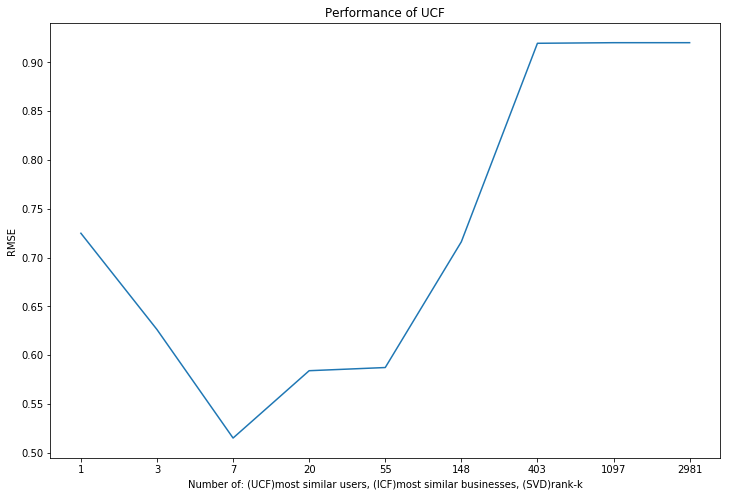

In [119]:
plt.figure(figsize=(12,8))

loc = (0, 1, 2, 3, 4, 5, 6, 7, 8)
lab = tuple(k_values)
plt.xticks(loc, lab)

plt.plot(array_r_UCF_RMSE)
plt.title("Performance of UCF")
plt.ylabel('RMSE')
plt.xlabel('Number of: (UCF)most similar users, (ICF)most similar businesses, (SVD)rank-k')
plt.show()

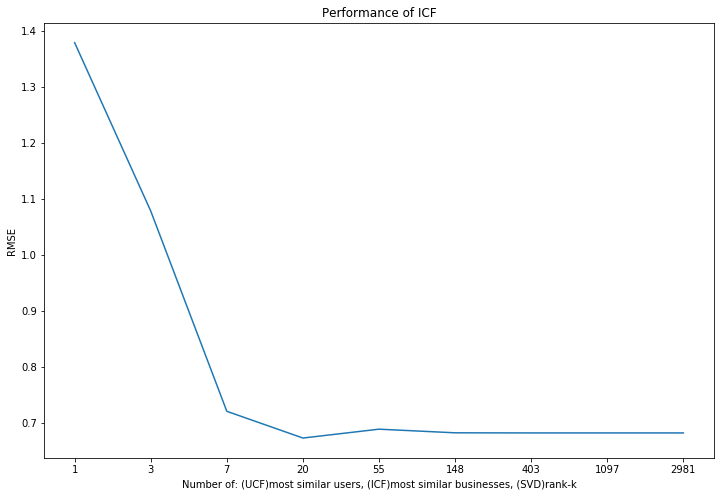

In [118]:
plt.figure(figsize=(12,8))

loc = (0, 1, 2, 3, 4, 5, 6, 7, 8)
lab = tuple(k_values)
plt.xticks(loc, lab)

plt.plot(array_r_ICF_RMSE)
plt.title("Performance of ICF")
plt.ylabel('RMSE')
plt.xlabel('Number of: (UCF)most similar users, (ICF)most similar businesses, (SVD)rank-k')
plt.show()

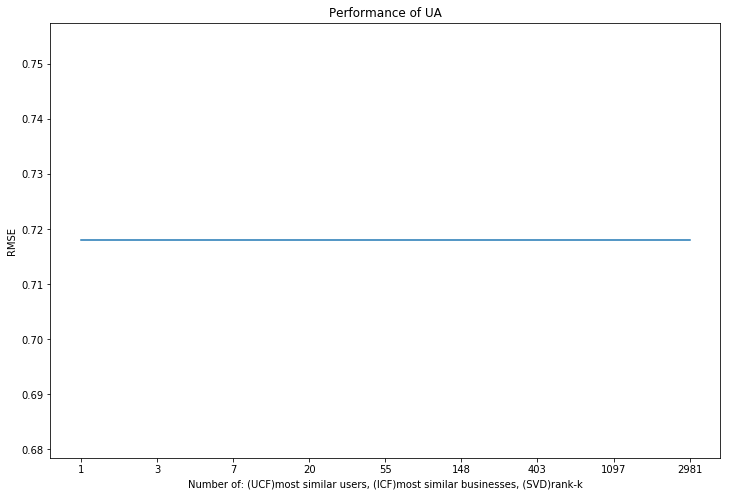

In [117]:
plt.figure(figsize=(12,8))

loc = (0, 1, 2, 3, 4, 5, 6, 7, 8)
lab = tuple(k_values)
plt.xticks(loc, lab)

plt.plot(array_r_UA_RMSE)
plt.title("Performance of UA")
plt.ylabel('RMSE')
plt.xlabel('Number of: (UCF)most similar users, (ICF)most similar businesses, (SVD)rank-k')
plt.show()

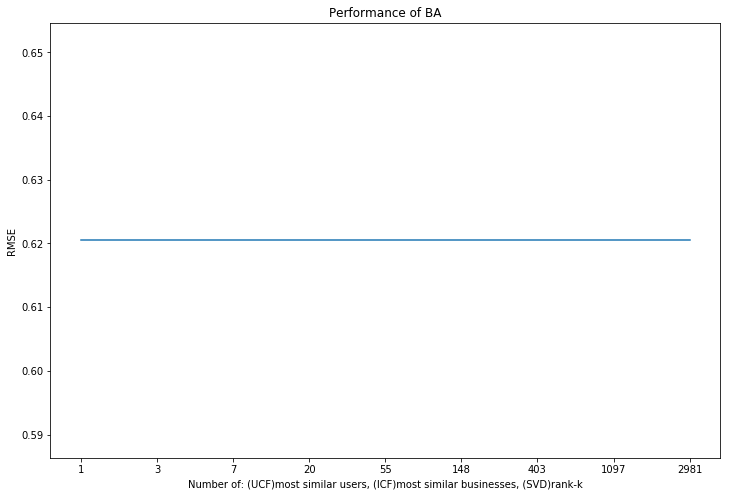

In [116]:
plt.figure(figsize=(12,8))

loc = (0, 1, 2, 3, 4, 5, 6, 7, 8)
lab = tuple(k_values)
plt.xticks(loc, lab)

plt.plot(array_r_BA_RMSE)
plt.title("Performance of BA")
plt.ylabel('RMSE')
plt.xlabel('Number of: (UCF)most similar users, (ICF)most similar businesses, (SVD)rank-k')
plt.show()

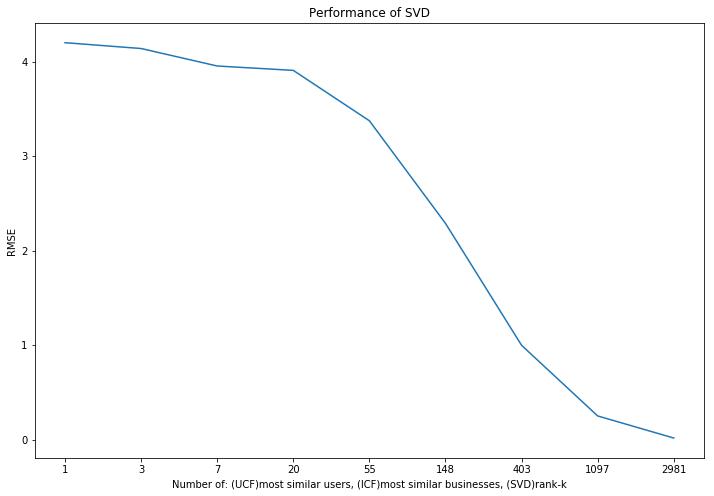

In [115]:
plt.figure(figsize=(12,8))

loc = (0, 1, 2, 3, 4, 5, 6, 7, 8)
lab = tuple(k_values)
plt.xticks(loc, lab)

plt.plot(array_r_SVD_RMSE)
plt.title("Performance of SVD")
plt.ylabel('RMSE')
plt.xlabel('Number of: (UCF)most similar users, (ICF)most similar businesses, (SVD)rank-k')
plt.show()

Creating lists with results for Absorbing Random Walks

In [82]:
temp_time = time.time()

random_ps10_ARW = []
complexity = 0.001

for i in range(number_of_ratings):
    temp_random_ps10_ARW = []
    temp_computed_Absorbing_Random_Walk = compute_Absorbing_Random_Walks(random_ps10[sample_info[i]][0], random_ps10[sample_info[i]][1], complexity)
    for j in range(number_of_k_values):
        temp_random_ps10_ARW.append(temp_computed_Absorbing_Random_Walk)
    random_ps10_ARW.append(temp_random_ps10_ARW)

print(str(time.time() - temp_time))

424.1663177013397


In [83]:
print(random_ps10_ARW)

[[3.772184794160109, 3.772184794160109, 3.772184794160109, 3.772184794160109, 3.772184794160109, 3.772184794160109, 3.772184794160109, 3.772184794160109, 3.772184794160109], [3.7343560280082584, 3.7343560280082584, 3.7343560280082584, 3.7343560280082584, 3.7343560280082584, 3.7343560280082584, 3.7343560280082584, 3.7343560280082584, 3.7343560280082584], [3.926353147239293, 3.926353147239293, 3.926353147239293, 3.926353147239293, 3.926353147239293, 3.926353147239293, 3.926353147239293, 3.926353147239293, 3.926353147239293], [3.57096293762721, 3.57096293762721, 3.57096293762721, 3.57096293762721, 3.57096293762721, 3.57096293762721, 3.57096293762721, 3.57096293762721, 3.57096293762721], [4.376096851505866, 4.376096851505866, 4.376096851505866, 4.376096851505866, 4.376096851505866, 4.376096851505866, 4.376096851505866, 4.376096851505866, 4.376096851505866], [3.1927667501970682, 3.1927667501970682, 3.1927667501970682, 3.1927667501970682, 3.1927667501970682, 3.1927667501970682, 3.19276675019

In [84]:
array_r_ARW = []

for i in range(number_of_k_values):
    temp_array_r_ARW = []
    for j in range(number_of_ratings):
        temp_array_r_ARW.append(random_ps10_ARW[j][i])
    array_r_ARW.append(temp_array_r_ARW)

In [85]:
print(array_r_ARW)

[[3.772184794160109, 3.7343560280082584, 3.926353147239293, 3.57096293762721, 4.376096851505866, 3.1927667501970682, 3.9155201790462484, 4.161059713008463, 3.2204805665140017, 4.322536389314541], [3.772184794160109, 3.7343560280082584, 3.926353147239293, 3.57096293762721, 4.376096851505866, 3.1927667501970682, 3.9155201790462484, 4.161059713008463, 3.2204805665140017, 4.322536389314541], [3.772184794160109, 3.7343560280082584, 3.926353147239293, 3.57096293762721, 4.376096851505866, 3.1927667501970682, 3.9155201790462484, 4.161059713008463, 3.2204805665140017, 4.322536389314541], [3.772184794160109, 3.7343560280082584, 3.926353147239293, 3.57096293762721, 4.376096851505866, 3.1927667501970682, 3.9155201790462484, 4.161059713008463, 3.2204805665140017, 4.322536389314541], [3.772184794160109, 3.7343560280082584, 3.926353147239293, 3.57096293762721, 4.376096851505866, 3.1927667501970682, 3.9155201790462484, 4.161059713008463, 3.2204805665140017, 4.322536389314541], [3.772184794160109, 3.73

Root Mean Square Error for ARW

In [86]:
temp_time = time.time()

array_r_ARW_RMSE = []

for i in range(number_of_k_values):
    array_r_ARW_RMSE.append( calculateRMSE(array_r_ARW[i], array_p) )

print(str(time.time() - temp_time))

0.0005574226379394531


In [87]:
print(array_r_ARW_RMSE)

[0.8350385237391625, 0.8350385237391625, 0.8350385237391625, 0.8350385237391625, 0.8350385237391625, 0.8350385237391625, 0.8350385237391625, 0.8350385237391625, 0.8350385237391625]


Plotting RMSE results for ARW

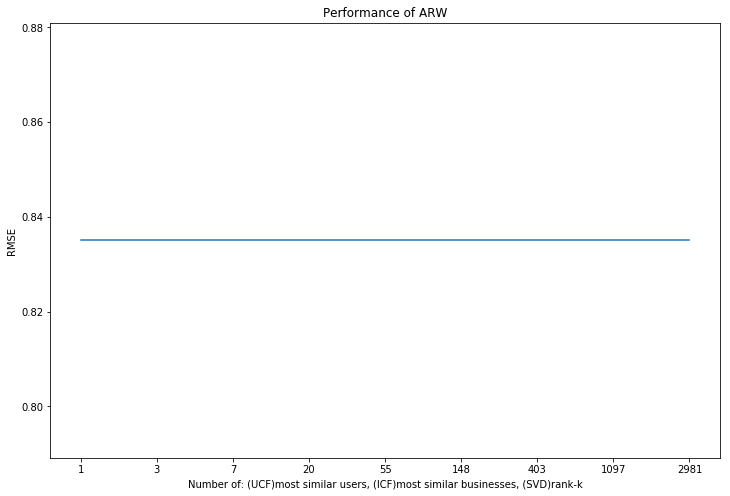

In [114]:
plt.figure(figsize=(12,8))

loc = (0, 1, 2, 3, 4, 5, 6, 7, 8)
lab = tuple(k_values)
plt.xticks(loc, lab)

plt.plot(array_r_ARW_RMSE)
plt.title("Performance of ARW")
plt.ylabel('RMSE')
plt.xlabel('Number of: (UCF)most similar users, (ICF)most similar businesses, (SVD)rank-k')
plt.show()

Plotting all RMSE results together

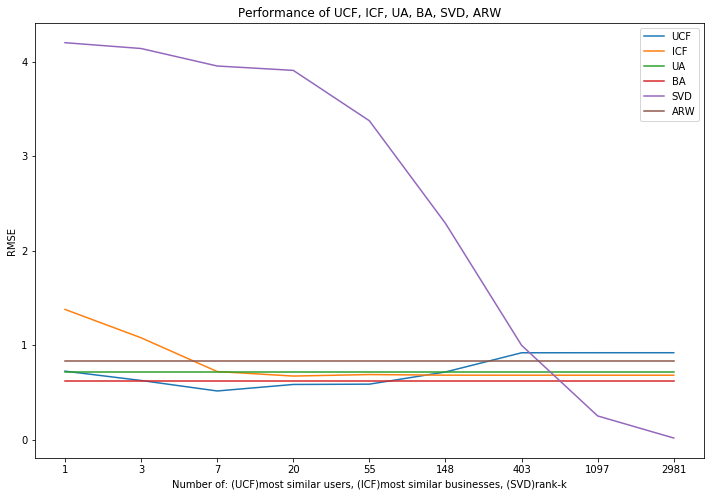

In [113]:
plt.figure(figsize=(12,8))

loc = (0, 1, 2, 3, 4, 5, 6, 7, 8)
lab = tuple(k_values)
plt.xticks(loc, lab)

plt.plot(array_r_UCF_RMSE)
plt.plot(array_r_ICF_RMSE)
plt.plot(array_r_UA_RMSE)
plt.plot(array_r_BA_RMSE)
plt.plot(array_r_SVD_RMSE)
plt.plot(array_r_ARW_RMSE)
plt.title("Performance of UCF, ICF, UA, BA, SVD, ARW")
plt.legend(("UCF", "ICF", "UA", "BA", "SVD", "ARW"), loc=0)
plt.ylabel('RMSE')
plt.xlabel('Number of: (UCF)most similar users, (ICF)most similar businesses, (SVD)rank-k')

plt.show()